## Churn Model for Telecom
Streamlabs Telecom has one major problem: our customers are leaving our service for competitors at an alarming rate. The task is to build a churn model to help build a model that can identify these customers going forward.

We took the following steps:
- Part I. Creation of the Training (70%) and Test Set (30%).
    1. We randomly split the data into the training and test set.
    2. We saved the training and test sets.
  
  
- Part II. Exploration of the Training Set
    1. We addressed the issue of null values.
    2. Identified and addressed churn class imbalance.
    3. Selected roc-auc score instead of accuracy as the evaluation metric due to class imbalance. 
 
 
- Part III. Feature Engineering
    1. We accounted for income and the number of users on the account.
   
   
- Part IV. Categorical Feature Exploration and Feature Selection.
    1. Chi-square test for categorical features relevant to churn.
    2. Visualization of the selected categorical features for churning and non-churning customers.


- Part V. Numerical Features Exploration and Feature Selection.
     1. Feature correlations with churn.
     2. Visualizations of the correlated features.
     3. Log-transformation of the numerical features.
     4. Identify features that have low correlation with churn.
     5. Standardization of the numerical features.
     
Part VI. Filter Methof of Feature Selection

Part VII. Train and Cross-Validate Supervised Models.
    1. Logistic regression (with l1 and l2 regularization).
    2. Random Forest.
    3. CatBoost.
    
    
Part VIIII. Train and Save the Models With the Best Hyperparameters.
    

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import joblib
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
import helper_functions as hf

In [2]:
# read in the data
customer_data = pd.read_csv('../cell_customer_data.csv')

In [3]:
customer_data.head()

,customer_id,revenue,mou,recurring_charge,director_assist,overage,roaming,minutes_delta,revenue_delta,dropped_calls,...,credit_card,accept_offer,new_user,existing_user,referrals,income,motorcycle,handset_price,retcall,churn
0,1047857.0,47.9150,290.00,59.990,0.0000,0.00,0.0000,-163.00,-0.4250,0.000000,...,1,0,0,0,0,6,0,79.98999,0,0
1,1089242.0,193.6225,1506.75,74.575,3.2175,196.25,9.5150,1187.25,156.8275,13.666667,...,1,0,1,0,0,6,0,79.98999,0,0
2,1055923.0,14.2725,148.50,10.000,0.0000,11.25,0.8975,-29.50,-4.2725,0.333333,...,1,0,0,0,0,6,0,0.00000,0,1
3,1092398.0,50.6800,870.50,59.990,0.4950,0.00,0.1950,-28.50,-0.6900,23.000000,...,0,0,0,0,0,0,0,149.98999,0,0
4,1063898.0,156.4375,1992.25,84.990,4.9500,255.00,0.0000,204.75,51.0225,31.000000,...,1,0,1,0,0,8,0,149.98999,0,0


In [4]:
customer_data.columns

Index(['customer_id', 'revenue', 'mou', 'recurring_charge', 'director_assist',
       'overage', 'roaming', 'minutes_delta', 'revenue_delta', 'dropped_calls',
       'blocked_calls', 'unanswered', 'customer_care', 'conference',
       'mou_received', 'outcalls', 'incalls', 'peaks', 'off_peaks',
       'call_forwarding', 'call_waiting', 'months', 'uniq_subs', 'active_subs',
       'phones', 'models', 'eqp_days', 'age1', 'age2', 'children', 'credit_a',
       'credit_aa', 'rural', 'suburban', 'town', 'refurbished', 'web_capable',
       'truck', 'rv', 'job_prof', 'job_clerical', 'job_crafts', 'job_student',
       'job_homemaker', 'job_retired', 'job_self', 'travel', 'pcown',
       'credit_card', 'accept_offer', 'new_user', 'existing_user', 'referrals',
       'income', 'motorcycle', 'handset_price', 'retcall', 'churn'],
      dtype='object')

In [5]:
customer_data.shape

(56837, 58)

## Part I. Train-Test 
To avoid exposure to the data that we will later use for evaluation, we will split the data set into the training and test sets. For data exploration, we will only use the training set.

In [6]:
# create a target variable from the 'churn' column
y = customer_data['churn']
# create features and exclude the 'churn' and customer_id columns
X = customer_data.drop(columns=['churn'])

In [7]:
# check to make sure the 'churn' column is not in features
'churn' in X.columns

False

### 1. Split the Dataset into Training (70%) and Test Set (30%)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=108)

In [9]:
# remove customer_id from the features 
X_train = X_train.drop(columns=['customer_id'])

### 2. Save The Training and Test Sets

In [10]:
# save the training set
pd.concat([X_train, y_train], axis=1).to_csv('data/training_set.csv', index=False)

# save the test set
pd.concat([X_test, y_test], axis=1).to_csv('data/test_set.csv', index=False)

In [11]:
# check the size of the training set
X_train.shape

(39785, 56)

In [12]:
# check the size of the test set
X_test.shape

(17052, 57)

## Part II. Exploration of the Training Set

In [13]:
X_train.shape

(39785, 56)

In [14]:
X_test.shape

(17052, 57)

### 1. Are there any null values?

To address the issue of missing data, we will replace the null values with the feature mean.

In [15]:
X_train.isnull().sum()[X_train.isnull().sum() > 0]

revenue             124
mou                 124
recurring_charge    124
director_assist     124
overage             124
roaming             124
minutes_delta       287
revenue_delta       287
phones                1
models                1
eqp_days              1
age1                711
age2                711
dtype: int64

In [16]:
# save the columns that have missing values
cols_with_missing = X_train.isnull().sum()[X_train.isnull().sum() > 0].index

In [17]:
# fill in any missing numerical values with the mean of that feature
X_train_no_missing = hf.fill_null_values(X_train, cols_with_missing)

In [18]:
# check to make sure there are no missing values 
X_train_no_missing.isnull().sum()[X_train_no_missing.isnull().sum() > 0]

Series([], dtype: int64)

### Missing Values for Income
It is more appropriate to replace 0 for the mean income as 0 used to incode missing income can introduce noise.

In [19]:
# replace 0 with mean income
X_train_no_missing['income'] = np.where(X_train_no_missing['income'] ==0, 
                                        X_train_no_missing['income'].mean(), 
                                        X_train_no_missing['income'])

### 2. Explore "Churn" Class Balance / Imbalance

In [20]:
# find out out how many customers are churning and not churning
y_train.value_counts()

0    28401
1    11384
Name: churn, dtype: int64

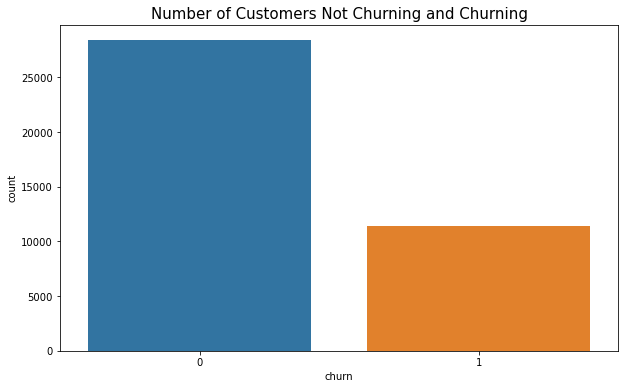

In [21]:
plt.figure(figsize=(10, 6))
plt.title('Number of Customers Not Churning and Churning', fontsize=15)
sns.countplot(y_train)
plt.show()

### 3. Findings (why accuracy should not be used an evaluation metric)
Our initial exploration revealed that our training data has many more than double of the customers that are not churning (class 0) vs. customers who are churning. We have a class imbalance and will have to address this issue. Additionally, this affects our choice of **the evaluation metric**. Simple accuracy would not be appropriate because the classifier could achieve a pretty high accuracy simply by predicting the dominant class (0). It is more fitting to use **roc auc score** (area under the curve). An ROC curve allows us to evalute the True Positive Rate (TPR), i.e., correctly classified churning customers, against the False Positive Rate (FPR), i.e., not churning customers who were incorrectly classified as churning at various thresholds. It will give us a better understanding how good our classifier is at predicting the churning customers than accuracy.


### 4. Address Class Imbalance - Undersampling
We will use undersampling (we will undersample the dominant class (not-churning customers)) to make the two classes more balanced. 

In [22]:
under = RandomUnderSampler()
steps = [('u', under)]
pipeline = Pipeline(steps=steps)
X_train_no_missing, y_train = pipeline.fit_resample(X_train_no_missing, y_train)

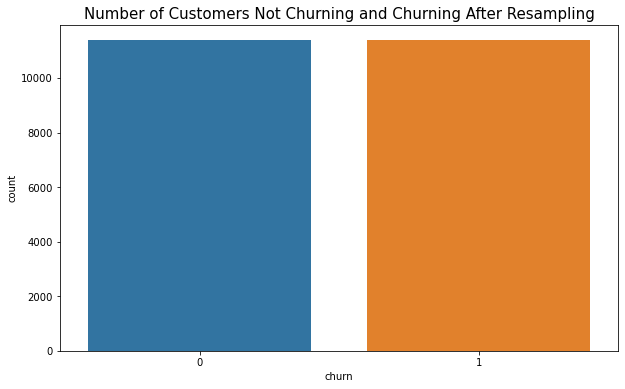

In [23]:
plt.figure(figsize=(10, 6))
plt.title('Number of Customers Not Churning and Churning After Resampling', fontsize=15)
sns.countplot(y_train)
plt.show()

### 5. Noisy Data (Negative Values)
We will explore if any datapoints have **negative values** as none of the features (except for the deltas) should have any negative values. We will replace the negative values with the feature mean.

In [24]:
numerical_features, categorical_features =  hf.numeric_and_categorical_features(X_train_no_missing)

In [25]:
X_train_no_missing.shape

(22768, 56)

In [26]:
# replace the noisy negative values in numerical cols with the mean
X_train_no_missing = hf.fill_negative_vals(X_train_no_missing, numerical_features)

## Part III. Feature Engineering

### 1. Account for Income and Number of Users

Due to time constaints, we will not have the ability to do an elaborate data engineering. Here, we will mainly address to issues:
- Normalize revenue (monthly average revenue) by income, as people with different incomes might find different amounts expensive.
- Normalize a number of features by the number of users, as the total amount may depend on the number of people contributing to the bill.

In [27]:
# find the ratio of revenue to income
X_train_no_missing['revenue'] = X_train_no_missing['revenue'] / X_train_no_missing['income']

In [28]:
columns_to_normalize = [
                        'revenue',
                        'mou',
                        'recurring_charge',
                        'director_assist', 
                        'overage',
                        'roaming',
                        'minutes_delta', 
                        'revenue_delta', 
                        'dropped_calls',
                        'blocked_calls',
                        'unanswered', 
                        'customer_care',
                        'mou_received',
                        'outcalls',
                        'incalls',
                        'peaks',
                        'off_peaks',
                        'call_forwarding',
                        'call_waiting',
                        'phones',
                        'models',
                        'accept_offer',
                        'referrals'
                        ]

In [29]:
# normalize the selected columns by the number of active users
X_train_no_missing = hf.normalize_by_users(X_train_no_missing, columns_to_normalize)

## Part IV. The Categorical Features Exploration and Feature Selection

### 1. Chi-Square Test For Categorical Features Relevant to Churn

Due to the time constraints, we will opt for the fastest method of feature selection - `filter method`. To filter the categories that are relevant to churn, we will use `the chi-square test`. The null hypothesis will be that the category does not affect the churn class. The alternative hypothesis will be that the category affects the churn class. The significance level will be set at 0.05. We will select the features that will have the p-value below 0.05.

In [30]:
# create a copy of the subset of the training data with categorical features for exploraiton
X_train_categorical = X_train_no_missing[categorical_features].copy()

In [31]:
# include the churn score from the training data for exploration
X_train_categorical['churn'] = y_train.tolist()

In [32]:
# use chi square for categorical feature selection using filter feature selection method
chi2_selection = SelectKBest(score_func=chi2, k='all')

In [33]:
# fit the model
fit = chi2_selection.fit(X_train_categorical[categorical_features], X_train_categorical['churn'])

In [34]:
# make a report with categories and p-values 
report_df = pd.DataFrame([categorical_features, fit.pvalues_]).T
report_df.columns = ['category', 'p_value']
relevant = report_df[report_df.p_value < 0.05].sort_values(by='p_value')
display(relevant)

,category,p_value
23,retcall,1.5435e-31
2,credit_aa,8.81211e-20
6,refurbished,1.63089e-06
1,credit_a,4.09735e-05
3,rural,0.000297437
7,web_capable,0.00219356
15,job_retired,0.0229497
20,new_user,0.032335


In [35]:
# save the features that did not show to significantly impact churn into a list
irrelevant_categorical = [feature for feature in categorical_features if feature not in relevant['category'].tolist()]

### 2. Visualizations of Selected Categorical Features For Churning and Non-Churning Customers

#### Retention Calls by Churning and Non-churning Customers

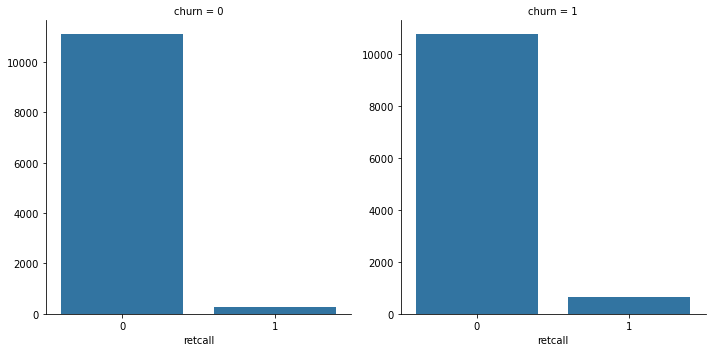

In [36]:
g = sns.FacetGrid(X_train_categorical, col='churn', height=5, margin_titles=True, sharey=False)
g.map(sns.countplot, 'retcall')
plt.show()

#### Highest Credit Rating of AA among Churning and Non-Churning Customers

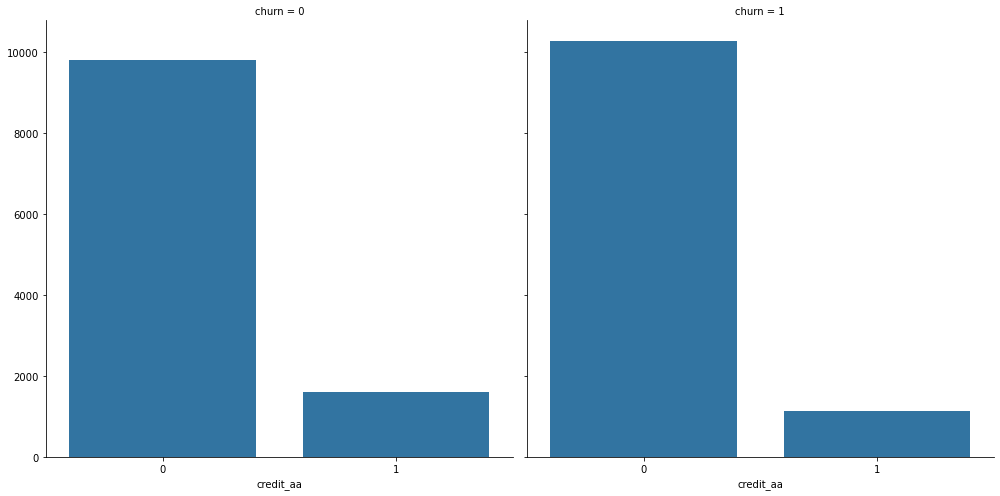

In [37]:
g = sns.FacetGrid(X_train_categorical, col='churn', height=7)
g.map(sns.countplot, 'credit_aa')
plt.show()

#### Refurbished Phones Among Churning and Non-Churning Customers

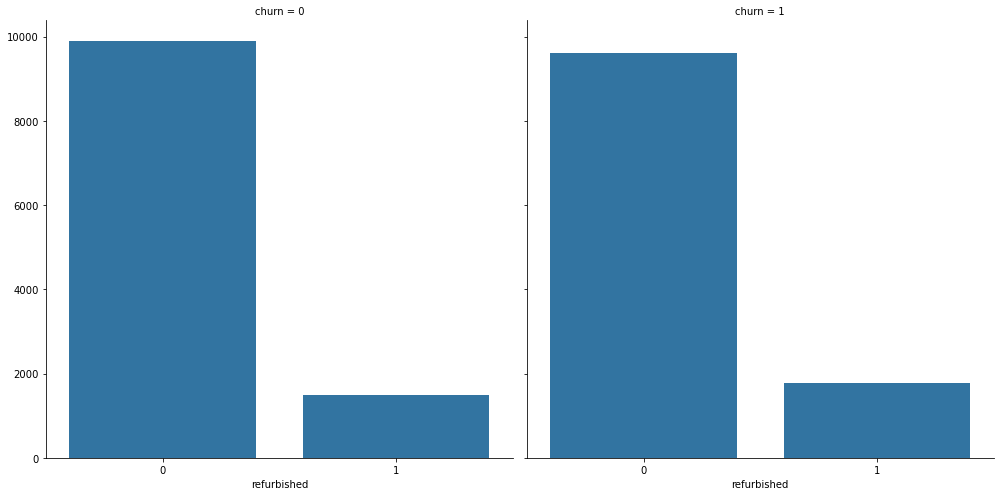

In [38]:
g = sns.FacetGrid(X_train_categorical, col='churn', height=7)
g.map(sns.countplot, 'refurbished')
plt.show()

#### Highest Credit Rating of A Among Churning and Non-Churning Customers

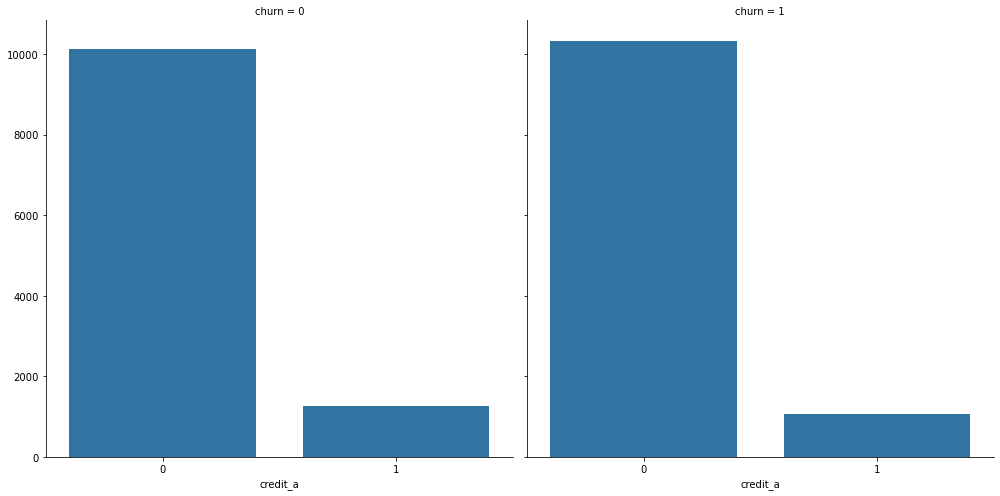

In [39]:
g = sns.FacetGrid(X_train_categorical, col='churn', height=7)
g.map(sns.countplot, 'credit_a')
plt.show()

#### Life in a Rural Area Among Churning and Non-Churning Customers

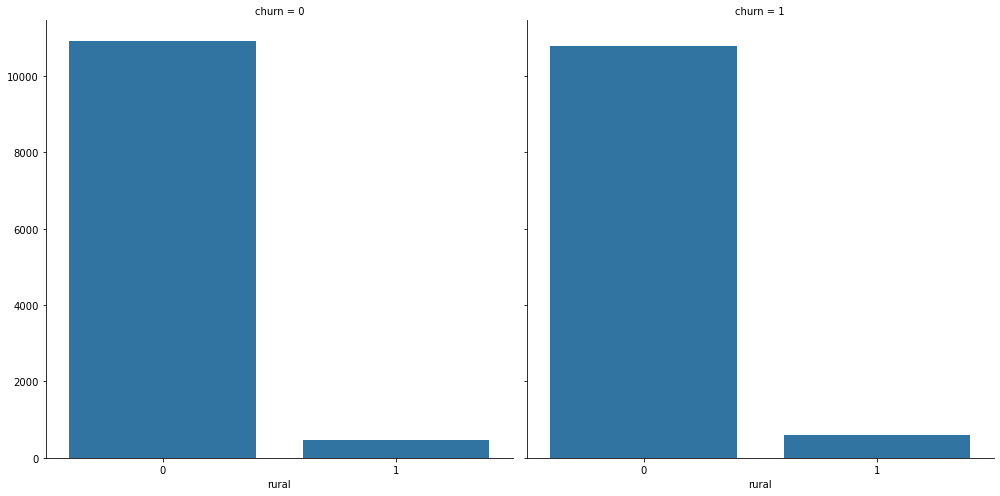

In [40]:
g = sns.FacetGrid(X_train_categorical, col='churn', height=7)
g.map(sns.countplot, 'rural')
plt.show()

#### Phones with Web Capabilities Among Churning and Non-Churning Customers

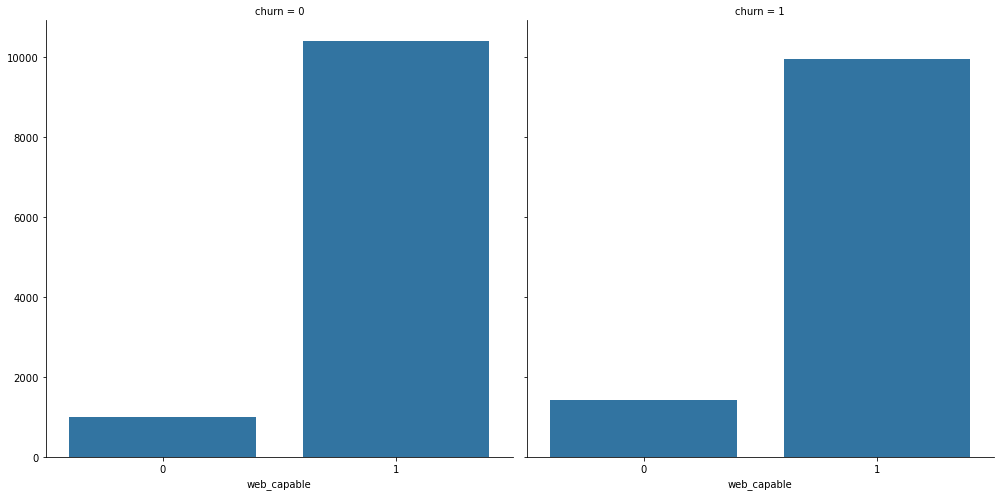

In [41]:
g = sns.FacetGrid(X_train_categorical, col='churn', height=7)
g.map(sns.countplot, 'web_capable')
plt.show()


#### Occupation - Retired Among Churning and Non-Churning Customers

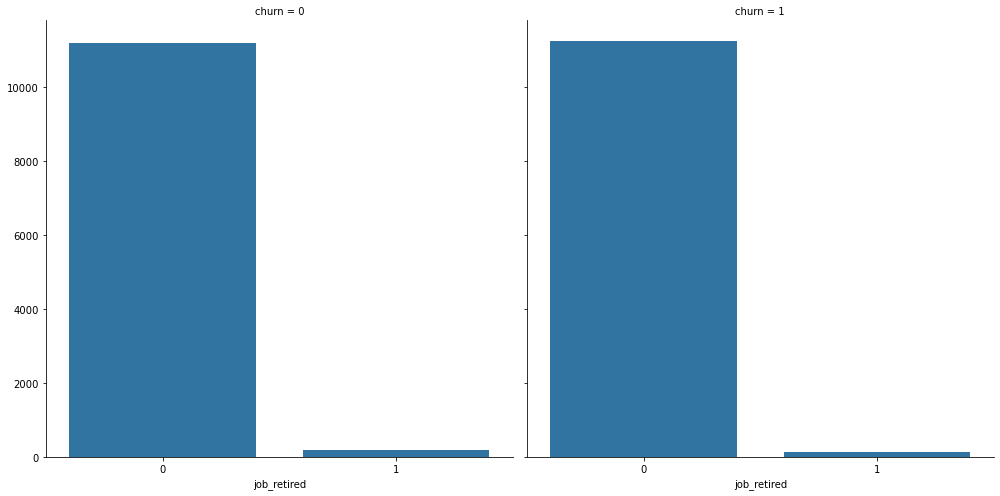

In [42]:
g = sns.FacetGrid(X_train_categorical, col='churn', height=7)
g.map(sns.countplot, 'job_retired')
plt.show()

#### New Cell Phone Users Among Churning and Non-Churning Customers

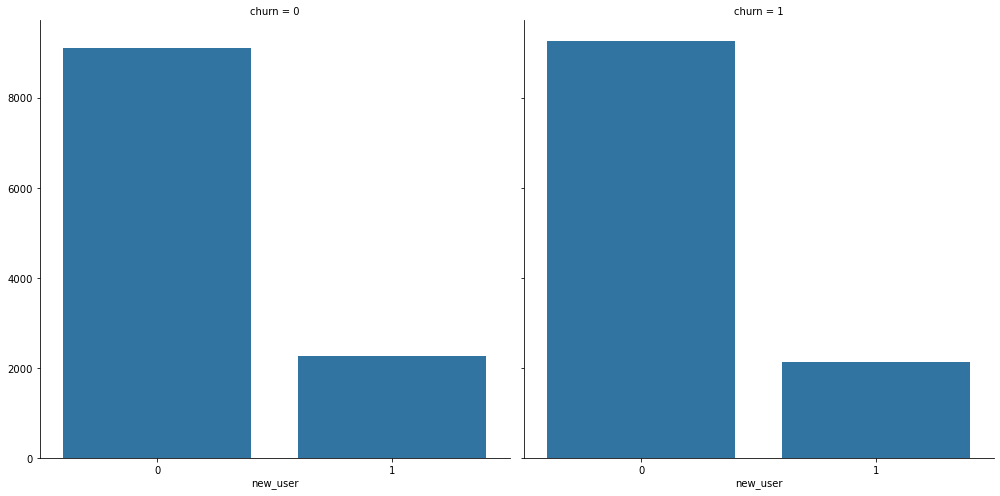

In [43]:
g = sns.FacetGrid(X_train_categorical, col='churn', height=7)
g.map(sns.countplot, 'new_user')
plt.show()

In [44]:
pd.DataFrame(X_train_categorical.groupby('churn')[['retcall', 
                                                   'credit_aa', 
                                                   'refurbished',
                                                   'credit_a',
                                                   'web_capable',
                                                   'rural',
                                                   'job_retired',
                                                   'new_user'
                                                   ]].sum())

,retcall,credit_aa,refurbished,credit_a,web_capable,rural,job_retired,new_user
churn,,,,,,,,
0,282,1599,1496,1264,10398,473,183,2272
1,636,1124,1770,1066,9961,591,142,2130


### Observations:
From our initial exploration of the categorical features, it appears that the churning customers:
- Tend to make more calls to the retention team;
- Tend to have credit rating AA and A less frequently;
- More often own a refurbished phone;
- Tend to be have phones with web capabilities less often;
- Have a slightly higher chance to live in a rural area;
- Are less likely to be retired;
- Are less likey to be a new user.

## Part V. Numerical Features Exploration and Feature Selection

### 1. Feature Correlations with Churn

Due to the time constraints, we will opt also for the fastest method of feature selection - filter method. To filter the categories that are relevant to churn, we will use correlation with the churn class.

In [45]:
# create the subset for exploring the numerical feature correlations
X_train_numerical = X_train_no_missing.copy()
X_train_numerical['churn'] = y_train.tolist()

In [46]:
# display the most correlted features with churn
# we care about both positive and negative correlations
# [1:] is necessary because churn will have 1.0 correlation with churn itself
X_train_numerical[numerical_features + ['churn']].corr()['churn'].sort_values(ascending=False)[1:].round(4)

eqp_days            0.1081
uniq_subs           0.0521
accept_offer        0.0406
active_subs         0.0220
months              0.0216
overage             0.0110
roaming             0.0107
revenue_delta       0.0057
income              0.0042
call_forwarding     0.0022
revenue            -0.0151
blocked_calls      -0.0180
referrals          -0.0203
age2               -0.0213
director_assist    -0.0219
dropped_calls      -0.0224
handset_price      -0.0235
conference         -0.0281
age1               -0.0339
call_waiting       -0.0348
minutes_delta      -0.0381
unanswered         -0.0413
outcalls           -0.0470
mou_received       -0.0486
incalls            -0.0494
customer_care      -0.0503
peaks              -0.0525
phones             -0.0542
off_peaks          -0.0563
models             -0.0631
mou                -0.0654
recurring_charge   -0.0780
Name: churn, dtype: float64

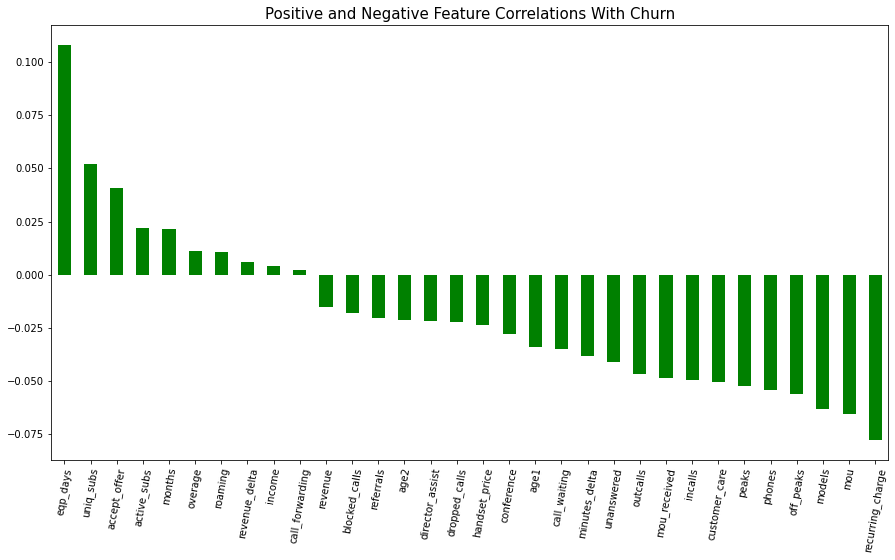

In [47]:
plt.figure(figsize=(15,8))
plt.title('Positive and Negative Feature Correlations With Churn', fontsize=15)
X_train_numerical[numerical_features + ['churn']].corr()['churn'].sort_values(ascending=False)[1:] \
            .plot(kind='bar', color='green')
plt.xticks(rotation=80)
plt.show()

### 2. Visualizations of The Numerical Features Most Correlated With Churn

#### Box Plots of the Features Positively Correlated With Churn

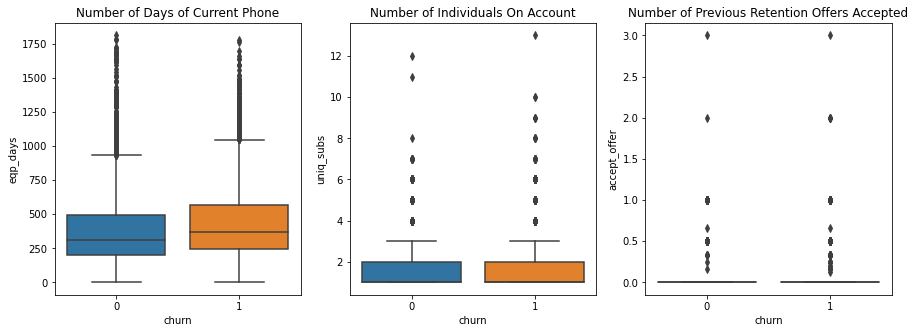

In [48]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title('Number of Days of Current Phone')
sns.boxplot(x=X_train_numerical['churn'], y=X_train_numerical['eqp_days'])
plt.subplot(132)
plt.title('Number of Individuals On Account')
sns.boxplot(x=X_train_numerical['churn'], y=X_train_numerical['uniq_subs'])
plt.subplot(133)
plt.title('Number of Previous Retention Offers Accepted')
sns.boxplot(x=X_train_numerical['churn'], y=X_train_numerical['accept_offer'])
plt.show()


We explored some of the numerical features that showed the highest positive correlation with the churn class. The `number of days of current phone` had a positive correlation coefficient of 0.1081, `the number of individuals on the account` had a positive correlation of 0.0521, `the number of previous retention offers accepted` had a positive correlation coefficient of 0.0406.  

Still, these correlation coefficients were rather small. From the boxplot, we could only really be somewhat sure that the churning customers tends to have more days of current phone, i.e., the longer they stay with the current phone, the more likely they are to churn. Higher number of individuals on the account seems to be also associated with a higher likelihood to churn. From the boxtplot, we cannot be so sure about the impact of the number of the previous retention offers accepted.

#### Features Negatively Correlated With Churn

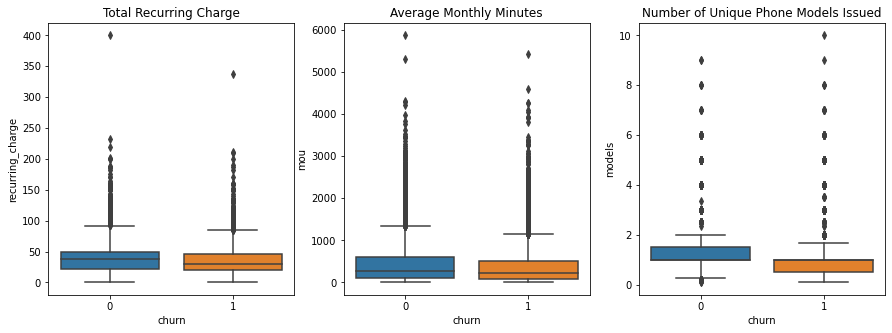

In [49]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title('Total Recurring Charge')
sns.boxplot(x=X_train_numerical['churn'], y=X_train_numerical['recurring_charge'])
plt.subplot(132)
plt.title('Average Monthly Minutes')
sns.boxplot(x=X_train_numerical['churn'], y=X_train_numerical['mou'])
plt.subplot(133)
plt.title('Number of Unique Phone Models Issued')
sns.boxplot(x=X_train_numerical['churn'], y=X_train_numerical['models'])
plt.show()


The higher amount of `the total recurring charge`, `average monthly minutes`, and `number of unique phones issued` are all negatively correlated with churning (the correlation coefficients are -0.078, -0.065, and -0.063 respectively). We can see the same trend from the visualization. The non-churnining customers tend to have a higher recurring charge, more monthly minutes, and more unique phone models. 

### 3. Log-Transform The Features
To make the features more correlated with the outcome (churn), we will log-transform them.

In [50]:
# save the columns with numerical values except for the deltas, we will use them for transformations
non_negative_numerical = [col for col in numerical_features if col not in ['minutes_delta', 'revenue_delta']]
# log-transform the non-negative numerical values
X_train_no_missing = hf.log_transform(X_train_no_missing, non_negative_numerical)

X_train_numerical_log = X_train_no_missing.copy()
X_train_numerical_log['churn'] = y_train.tolist()

#### Feature Correlations with Churn after Log-Transform

In [51]:
# display the most correlted features with churn
# we care about both positive and negative correlations
# [1:] is necessary because churn will have 1.0 correlation with churn itself
X_train_numerical_log[numerical_features + ['churn']].corr()['churn'].sort_values(ascending=False)[1:].round(4)

eqp_days            0.1094
uniq_subs           0.0560
months              0.0501
active_subs         0.0255
overage             0.0209
roaming             0.0184
revenue_delta       0.0057
income              0.0039
call_forwarding     0.0013
conference         -0.0041
referrals          -0.0053
director_assist    -0.0130
age2               -0.0170
age1               -0.0264
blocked_calls      -0.0270
dropped_calls      -0.0285
call_waiting       -0.0316
accept_offer       -0.0320
handset_price      -0.0343
revenue            -0.0371
minutes_delta      -0.0381
customer_care      -0.0522
mou_received       -0.0523
outcalls           -0.0593
unanswered         -0.0601
incalls            -0.0622
phones             -0.0685
peaks              -0.0711
off_peaks          -0.0734
models             -0.0736
recurring_charge   -0.0773
mou                -0.0938
Name: churn, dtype: float64

Log-transform helped us improve correlations coefficients, e.g., mou (on a log scale) is now stronger negatively correlated with churn (-0.094 vs. -0.065 before the transformation).

### 4. Identify Features With Low Correlation With Churn
Here, we will define low correlation as having the absolute value of the correlation coefficient below 0.01.

In [56]:
# identify features that have the absolute value of the correlation coefficient with churn below 0.01
low_corr = X_train_numerical_log[numerical_features + ['churn']].corr()['churn'].sort_values(ascending=False)[
                                np.abs(X_train_numerical_log[numerical_features + \
                                ['churn']].corr()['churn'].sort_values(ascending=False)) < 0.01]

# save the names of these features
features_low_corr = low_corr.index

print('Numerical features that have a low correlation coefficient with churn:', ', '.join(features_low_corr.tolist()))

Numerical features that have a low correlation coefficient with churn: revenue_delta, income, call_forwarding, conference, referrals


### Drop "Churn" to Avoid Data Leakage
We used "churn" column for correlations analysis. Now we need to drop it.

In [57]:
X_train_numerical_log = X_train_numerical_log.drop(['churn'], axis=1)

### 5. Standardize the Numerical Features
To make sure all the numerical features are on the same scale, it is necessary to standardize them, i.e, turn them into z-scores.


In [58]:
# initialize the scaler
scaler = StandardScaler()

# standardize the numerical features
X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_numerical_log[numerical_features]),
                                                       columns = numerical_features)

# combine the numerical features with the categorical
combined_training_df = pd.concat([X_train_num_scaled, X_train_no_missing[categorical_features]], axis=1)

In [59]:
filename = 'finalized_model.sav'
joblib.dump(scaler, 'models/scaler.sav')

['models/scaler.sav']

In [60]:
combined_training_df.columns

Index(['revenue', 'mou', 'recurring_charge', 'director_assist', 'overage',
       'roaming', 'minutes_delta', 'revenue_delta', 'dropped_calls',
       'blocked_calls', 'unanswered', 'customer_care', 'conference',
       'mou_received', 'outcalls', 'incalls', 'peaks', 'off_peaks',
       'call_forwarding', 'call_waiting', 'months', 'uniq_subs', 'active_subs',
       'phones', 'models', 'eqp_days', 'age1', 'age2', 'accept_offer',
       'referrals', 'income', 'handset_price', 'children', 'credit_a',
       'credit_aa', 'rural', 'suburban', 'town', 'refurbished', 'web_capable',
       'truck', 'rv', 'job_prof', 'job_clerical', 'job_crafts', 'job_student',
       'job_homemaker', 'job_retired', 'job_self', 'travel', 'pcown',
       'credit_card', 'new_user', 'existing_user', 'motorcycle', 'retcall'],
      dtype='object')

In [61]:
# make sure the training data is not leaking the target variable
['churn' in combined_training_df.columns]

[False]

In [62]:
combined_training_df.shape

(22768, 56)

## Part VI. Filter Method of Feature Selection
Some features have very low correlation coefficients with churn, which we define here as having the absolute value below 0.01. We will exclude them from modeling, i.e., use filter method of feature selection based on correlations. For categorical features, we used chi-square test and filtered out such features that had limited impact on churn (p-value of being the same in the churn and non-churn class over 0.05).

In [63]:
# features we should filter out based on analysis
features_to_remove = features_low_corr.tolist() + irrelevant_categorical 

# remove filtered out features
combined_training_df = combined_training_df.drop(features_to_remove, axis=1)

In [64]:
len(features_to_remove)

21

In [65]:
combined_training_df.shape

(22768, 35)

## Part VII. Trained Supervised Models on the Training Set With Cross-Valiation

Here, we will train Logistic Regression (with l1 and l2 regularization), Random Forest, and CatBoost on the training data with 3-fold cross validation. In the process, we will fine-tune hyper-parameters of each of the algorithm and select the best-performing hyper-parameters. We will use roc-auc score as the evaluation metric.

### 1. Logistic Regression

We will select the best hyper-parameters, including the regularization method (penalty) as either `l1 - Lasso` or `l2 Ridge` as well as the regularization coefficient. These regularized models have embedded feature selection as they lower the coefficients for the least important features. They also address the issue of correlated features.

In [66]:
# select the best hyper-parameters, including the regularization method (penalty) as either l1 - Lasso or l2 Ridge
param_grid = [
            {'C': [1e-20, 1e-3,1e-3,  10, 1e2, 1e3],
            'penalty': ['l1', 'l2']}
            ]
# initialize the logistic regression
lr = LogisticRegression()
grid_search = GridSearchCV(lr, 
                           param_grid, 
                           cv=3,
                           scoring='roc_auc', 
                           verbose=1)
# fit the model
grid_search.fit(combined_training_df, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.9s finished


GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid=[{'C': [1e-20, 0.001, 0.001, 10, 100.0, 1000.0],
                          'penalty': ['l1', 'l2']}],
             scoring='roc_auc', verbose=1)

In [67]:
print('Best score', grid_search.best_score_)
print('Best parameters', grid_search.best_params_)

Best score 0.6211495314053863
Best parameters {'C': 1000.0, 'penalty': 'l2'}


### 2. Random Forest

In [68]:
# define hypermarameters to test
param_grid_rfc = [
                 {'n_estimators': [100, 500, 700],
                 'max_depth': [5, 8, 12, 20, 30]}
                 ]
# initialize the random forest classifier
rfc = RandomForestClassifier(n_jobs = -1)

grid_search_rfc = GridSearchCV(rfc, param_grid_rfc, 
                               cv=3,
                               scoring='roc_auc', 
                               verbose=0,
                               n_jobs =-1)
# fit the model
grid_search_rfc.fit(combined_training_df, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid=[{'max_depth': [5, 8, 12, 20, 30],
                          'n_estimators': [100, 500, 700]}],
             scoring='roc_auc')

In [69]:
print('Best score', grid_search_rfc.best_score_)
print('Best parameters', grid_search_rfc.best_params_)

Best score 0.6559224844895212
Best parameters {'max_depth': 12, 'n_estimators': 700}


In [70]:
# try to see if roc-auc score improves with more estimators
param_grid_rfc = [{'n_estimators': [1000, 1200]}]
# initialize the random forest classifier
rfc = RandomForestClassifier(n_jobs = -1, max_depth=12)
grid_search_rfc = GridSearchCV(rfc, 
                               param_grid_rfc, 
                               cv=3,
                               scoring='roc_auc', 
                               verbose=0,
                               n_jobs=-1)
# fit the model
grid_search_rfc.fit(combined_training_df, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(max_depth=12, n_jobs=-1),
             n_jobs=-1, param_grid=[{'n_estimators': [1000, 1200]}],
             scoring='roc_auc')

In [71]:
print('Best score', grid_search_rfc.best_score_)
print('Best parameters', grid_search_rfc.best_params_)

Best score 0.6558002371278514
Best parameters {'n_estimators': 1000}


### 3. CatBoost Classifier

In [72]:
# define hyperparameters
param_grid = {'iterations': [100, 300, 500], 
              'depth': [4, 6, 10],
              'learning_rate': [0.5, 0.1]}
# initialize the model
cat_boost = CatBoostClassifier(verbose=0)
# perform cross-validation 
grid_search_cat = GridSearchCV(cat_boost, 
                               param_grid, 
                               cv=3,
                               scoring= 'roc_auc', 
                               verbose=0, 
                               n_jobs=-1)
# fit the model
grid_search_cat.fit(combined_training_df, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fbdbfd77c90>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 10], 'iterations': [100, 300, 500],
                         'learning_rate': [0.5, 0.1]},
             scoring='roc_auc')

In [73]:
print('Best score', grid_search_cat.best_score_)
print('Best parameters', grid_search_cat.best_params_)

Best score 0.661515180891597
Best parameters {'depth': 4, 'iterations': 300, 'learning_rate': 0.1}


In [74]:
# see if a more shallow tree depth would help
param_grid = {'depth': [2]}
# initialize the model
cat_boost = CatBoostClassifier(verbose=0, 
                               iterations=300, 
                               learning_rate=0.1)

grid_search_cat = GridSearchCV(cat_boost, 
                               param_grid, 
                               cv=3,
                               scoring= 'roc_auc', 
                               verbose=0, 
                               n_jobs=-1)
# fit the models
grid_search_cat.fit(combined_training_df, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fbdc0a5fb50>,
             n_jobs=-1, param_grid={'depth': [2]}, scoring='roc_auc')

In [75]:
print('Best score', grid_search_cat.best_score_)
print('Best parameters', grid_search_cat.best_params_)

Best score 0.6576465018457499
Best parameters {'depth': 2}


## Part VIII. Train and Save the Models With The Best Hyperparameters

In [76]:
# train and save logistic regression
lr_best = LogisticRegression(C= 1000, 
                             penalty= 'l2')
lr_best.fit(combined_training_df, y_train)

LogisticRegression(C=1000)

In [78]:
# save the model to 'models' folder
joblib.dump(lr_best, 'models/logistic_regression.sav')

['models/logistic_regression.sav']

In [79]:
# train and save Random Forest
rfc_best = RandomForestClassifier(max_depth=12, 
                                  n_estimators=700, 
                                  n_jobs = -1)
rfc_best.fit(combined_training_df, y_train)

RandomForestClassifier(max_depth=12, n_estimators=700, n_jobs=-1)

In [80]:
# save the model to 'models' folder
joblib.dump(rfc_best, 'models/random_forest.sav')

['models/random_forest.sav']

In [81]:
# train 
cat_best = CatBoostClassifier(iterations=300, 
                              max_depth=4, 
                              learning_rate=0.1, 
                              verbose=0)
cat_best.fit(combined_training_df, y_train)

In [82]:
# save the model to 'models' folder
joblib.dump(cat_best, 'models/catboost.sav')

['models/catboost.sav']

In [84]:
# make a note of the features we filtered out
print('Removed features:',
      features_to_remove)

Removed features: ['revenue_delta', 'income', 'call_forwarding', 'conference', 'referrals', 'children', 'suburban', 'town', 'truck', 'rv', 'job_prof', 'job_clerical', 'job_crafts', 'job_student', 'job_homemaker', 'job_self', 'travel', 'pcown', 'credit_card', 'existing_user', 'motorcycle']


### Testing The Models
We test these pre-trained models in the notebook "Validation_On_Test_Set."